
# Twitter data analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Data gathering</a></li>
<li><a href="#Assessing">Assessing</a></li>
<li><a href="#Cleaning">Cleaning</a></li>
<li><a href="#Storing">Storing</a></li>
<li><a href="#viz">Analyzing and Visualizing</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [1]:
# imports 
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

<a id='intro'></a>
# Introduction

> In this project, I analyze tweets from [@WeRateDogs](https://twitter.com/dog_rates) twitter account. WeRateDogs is a Twitter account with more than eight million followers that rates people's dogs with a humorous comment about the dog.
<br>
I will gather the data using the twitter API.

------------------------------------

<a id='gathering'></a>
## Data gathering

#### Read data from a CSV file

In [2]:
#Read twitter-archive-enhanced.csv file
df_csv = pd.read_csv('twitter-archive-enhanced.csv', index_col='tweet_id')
df_csv.head(3)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


#### Download file

In [3]:
#Download image_predictions.tsv file
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open(os.path.join('image_predictions.tsv'), mode='wb') as file:
    file.write(r.content)

# Read the downloaded file    
df_tsv = pd.read_csv('image_predictions.tsv', sep='\t', index_col='tweet_id')
df_tsv.head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Twitter API

In [4]:
# Connect to twitter APIs
# I have stored authuntication information in auth.json file for security reasons

auth = json.load(open('auth.json'))

consumer_key = auth['consumer_key']
consumer_secret = auth['consumer_secret']
access_token = auth['access_token']
access_secret = auth['access_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [5]:
# Check contents of a tweet response
json_keys =[]
tweet = api.get_status(892420643555336193)


In [6]:
# Get all dictionary keys recursively
keys = []
def getAllKeys(d):
    for key, value in d.items():
        keys.append(key)
        if type(value) is dict:
            getAllKeys(value)
    return keys     

In [7]:
# Print tweet's properties
print(getAllKeys(tweet._json))

['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'hashtags', 'symbols', 'user_mentions', 'urls', 'media', 'extended_entities', 'media', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'url', 'urls', 'description', 'urls', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_banner_url', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image'

#### From the tweet properties above I select the following properties to store in the JSON file
1. tweet_id
* created_at
* favorite_count
* retweet_count
* tweet_status_ok (If status exists true else false)
 

In [8]:
# Read tweets with tweet id and save them in a json file
error_list=[]
with open('tweet_json.txt', 'w') as file:
    for t in np.array(df_csv.index):
        try:
            tweet = api.get_status(t)
            created_at = str(tweet.created_at)
            favorite_count = tweet.favorite_count
            retweet_count = tweet.retweet_count
            tweet_status_ok = True
        except Exception as e:
            error_list.append(str(t))

        j ={'tweet_id':int(t),
                        'created_at':str(created_at),
                        'favorite_count':int(favorite_count),
                        'retweet_count':int(retweet_count),
                        'tweet_status_ok': tweet_status_ok}
        json.dump(j,file)
        file.write('\n')

Rate limit reached. Sleeping for: 674
Rate limit reached. Sleeping for: 673


In [8]:
# Read JSON file
json_list=[]
df_json = pd.DataFrame(json_list, columns=['tweet_id','created_at','favorite_count','retweet_count','tweet_status_ok'])

with open('tweet_json.txt','r') as file:
    for line in file:
        d = json.loads(line)
        df_json = df_json.append(d, ignore_index=True)      

df_json.head()

,tweet_id,created_at,favorite_count,retweet_count,tweet_status_ok
0,892420643555336193,2017-08-01 16:23:56,36600,7789,True
1,892177421306343426,2017-08-01 00:17:27,31536,5771,True
2,891815181378084864,2017-07-31 00:18:03,23755,3820,True
3,891689557279858688,2017-07-30 15:58:51,39927,7961,True
4,891327558926688256,2017-07-29 16:00:24,38124,8598,True


------------------------------

<a id='intro'></a>
# Assessing

#### Unclean Data: Dirty vs. Messy

>There are two types of unclean data:
>* **Dirty** data, also known as **low quality** data. Low quality data has **content issues**.
>* **Messy** data, also known as **untidy data**. Untidy data has **structural issues**.

#### Visual Assesment 

In [9]:
df_csv.head() 
#also checked
#df_csv.head(50)
#df_csv.tail(50)
#df_csv.sample(50)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
df_tsv.head() 
#also checked
#df_tsv.head(50)
#df_tsv.tail(50)
#df_tsv.sample(50)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [11]:
df_json.head()
#also checked
#df_json.head(50)
#df_json.tail(50)
#df_json.sample(50)

,tweet_id,created_at,favorite_count,retweet_count,tweet_status_ok
0,892420643555336193,2017-08-01 16:23:56,36600,7789,True
1,892177421306343426,2017-08-01 00:17:27,31536,5771,True
2,891815181378084864,2017-07-31 00:18:03,23755,3820,True
3,891689557279858688,2017-07-30 15:58:51,39927,7961,True
4,891327558926688256,2017-07-29 16:00:24,38124,8598,True


#### Quality issues:
> **`df_csv`:** 
* `source` is in form of a html tag.
* Some `name`s are null.
* There is a `+0000` at the end the time in `timestamp` column.
* There is a `+0000` at the end the time in `retweeted_status_timestamp` column (if it is not null).
* Nulls represented as None in `doggo`, `floofer`,`pupper` and `puppo` columns.
* In the `name` column, there are several `None` values.

>**`df_tsv`:**
* Some values include underlines in `p1` and `p2` columns.
* Values in `p1` and `p1` are not consistant (Capital or not). 

>**`df_json`:**
* No considerable visual issue

#### Tidiness issues:
> **`df_csv`:** 
* Four seprated columns for  `doggo`, `floofer`,`pupper` and `puppo` instead of one column as `stage`.
* We are only intrested on tweets not retweets or replys.

>**`df_tsv`:**
* Columns' title are not descriptive.

>**`df_json`:**
* `tweet_id` should be index of the table

### Programatical Assesment

In [12]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), object(10)
memory usa

In [13]:
df_csv.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
# Check if a dog has more than one stages
print('doggo and floofer: ',df_csv.query('(doggo == "doggo" and floofer == "floofer")').shape[0])
print('doggo and pupper:  ',df_csv.query('(doggo == "doggo" and pupper == "pupper")').shape[0])
print('doggo and puppo:   ', df_csv.query('(doggo == "doggo" and puppo == "puppo")').shape[0])
print(df_csv.query('(floofer == "floofer" and puppo == "puppo")').shape[0])
print(df_csv.query('(floofer == "floofer" and pupper == "pupper")').shape[0])
print(df_csv.query('(puppo == "puppo" and pupper == "pupper")').shape[0])
print(df_csv.query('pupper == "pupper" and doggo == "doggo" and floofer == "floofer"').shape[0])
print(df_csv.query('puppo == "puppo" and doggo == "doggo" and floofer == "floofer"').shape[0])
print(df_csv.query('puppo == "puppo" and pupper == "pupper" and floofer == "floofer"').shape[0])
print(df_csv.query('puppo == "puppo" and pupper == "pupper" and doggo == "doggo"').shape[0])
print(df_csv.query('puppo == "puppo" and pupper == "pupper" and doggo == "doggo" and floofer == "floofer"').shape[0])

doggo and floofer:  1
doggo and pupper:   12
doggo and puppo:    1
0
0
0
0
0
0
0
0


In [15]:
# Check name values
df_csv['name'].value_counts().head(10)

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
Tucker      10
Lola        10
Penny       10
Bo           9
Name: name, dtype: int64

In [16]:
# Check names that the first letter is lower case. Most probably they are not valid names.
lower_case_names = df_csv['name'].apply(lambda x : x[:1].islower())
df_csv[lower_case_names]['name'].value_counts()

a               55
the              8
an               7
very             5
one              4
just             4
quite            4
not              2
mad              2
actually         2
getting          2
light            1
space            1
infuriating      1
incredibly       1
his              1
unacceptable     1
my               1
all              1
by               1
such             1
officially       1
life             1
this             1
old              1
Name: name, dtype: int64

In [17]:
df_tsv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
jpg_url    2075 non-null object
img_num    2075 non-null int64
p1         2075 non-null object
p1_conf    2075 non-null float64
p1_dog     2075 non-null bool
p2         2075 non-null object
p2_conf    2075 non-null float64
p2_dog     2075 non-null bool
p3         2075 non-null object
p3_conf    2075 non-null float64
p3_dog     2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [18]:
df_tsv.describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


In [19]:
# Check if there config value order is correct
df_tsv.query('(p3_conf > p2_conf) or (p2_conf > p1_conf)').shape[0]

0

In [20]:
#Check the p1_dog column to make sure we have only true and false
df_tsv['p1_dog'].value_counts()
#Also checked
#df_tsv['p2_dog'].value_counts()
#df_tsv['p3_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [21]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
tweet_id           2356 non-null object
created_at         2356 non-null object
favorite_count     2356 non-null object
retweet_count      2356 non-null object
tweet_status_ok    2356 non-null object
dtypes: object(5)
memory usage: 92.1+ KB


In [22]:
df_json.describe()

,tweet_id,created_at,favorite_count,retweet_count,tweet_status_ok
count,2356,2356,2356,2356,2356
unique,2356,2331,1975,1677,1
top,667495797102141441,2016-08-30 23:58:40,0,281,True
freq,1,2,164,5,2356


#### Quality issues:
> **`df_csv`:** 
* There is values other than 10 for `rating_denominator`. Values such as 170, 150 and 2 do not look logical in this column.
* Expected value for `rating_numerator` is between `10` and `15` but we have values such as 201, 1776, 1 and etc.
* Data type for `timestamp` is string (object) it should be datetime
* 14 of the dogs has more than one stages.
* 745 names are None.
* There are some invalid names such as `a`, `an`, `the`, `very`etc.


>**`df_tsv`:**
* No considerable issue

>**`df_json`:**
* No considerable issue

#### Tidiness issues:

* No considerable  issue


### All the issues combined:
#### Quality issues:
> **`df_csv`:** 
* `source` is in the form of an html tag.
* There is a `+0000` at the end the time in the `timestamp` column.
* There is a `+0000` at the end the time in the `retweeted_status_timestamp` column (if it is not null).
* Nulls represented as None in `doggo`, `floofer`,`pupper` and `puppo` columns.
* In the `name` column, there are several `None` values.
* There is values other than 10 for `rating_denominator`. Values such as 170, 150 and 2 do not look logical in this column.
* Expected value for `rating_numerator` is between `10` and `15` but we have values such as 201, 1776, 1 and etc.
* Data type for `timestamp` is string (object) it should be DateTime
* 14 of the dogs has more than one stages.
* There are some invalid names such as `a`, `an`, `the`, `very`etc.

>**`df_tsv`:**
* Values in `p1` and `p1` are not consistant (Capital or not). 

>**`df_json`:**
* No considerable visual issue

#### Tidiness issues:
> **`df_csv`:** 
* Four seprated columns for  `doggo`, `floofer`,`pupper` and `puppo` instead of one column as `stage`.
* We are only intrested on tweets not retweets or replys.

>**`df_tsv`:**
* Columns' title are not descriptive.

>**`df_json`:**
* `tweet_id` should be index of the table

--------------

<a id='Cleaning'></a>
# Cleaning
I will address all the issues found in the assessment phase.

In [198]:
# Make a copy of each dataframe
df_csv_clean = df_csv.copy()
df_tsv_clean = df_tsv.copy()
df_json_clean = df_json.copy()

#### Define (1)
`name column`: Convert None to NaN. (Handel missing values) (We cannot do anything about the null names but at least we can convert then to NaN so we know we have null values)

#### Code

In [199]:
# 1. Convert None to NaN. (Handel missing values)
# Code: 
df_csv_clean.name.replace('None', np.NaN,inplace = True)
# 745 records updated

#### Test

In [200]:
# Test:
print(df_csv_clean.query('name == "None"').shape[0])
print(df_csv_clean[df_csv_clean['name'].isna()].shape[0])

0
745


______________________________
#### Define (2)
`doggo, floofer,pupper and puppo columns`: Convert None to NaN.(Handel missing values)

#### Code

In [201]:
# 2. Convert None to NaN on doggo, floofer,pupper and puppo columns.(Handel missing values)
# Code:
df_csv_clean.doggo.replace('None', np.NaN,inplace = True)
df_csv_clean.floofer.replace('None', np.NaN,inplace = True)
df_csv_clean.pupper.replace('None', np.NaN,inplace = True)
df_csv_clean.puppo.replace('None', np.NaN,inplace = True)

#### Test

In [202]:
# Test
print('doggo:')
print(df_csv_clean.query('doggo == "None"').shape[0])
print(df_csv_clean[df_csv_clean['doggo'].isna()].shape[0])
print('floofer:')
print(df_csv_clean.query('floofer == "None"').shape[0])
print(df_csv_clean[df_csv_clean['floofer'].isna()].shape[0])
print('pupper:')
print(df_csv_clean.query('pupper == "None"').shape[0])
print(df_csv_clean[df_csv_clean['pupper'].isna()].shape[0])
print('puppo:')
print(df_csv_clean.query('puppo == "None"').shape[0])
print(df_csv_clean[df_csv_clean['puppo'].isna()].shape[0])

doggo:
0
2259
floofer:
0
2346
pupper:
0
2099
puppo:
0
2326


______________________________
#### Define (3)
`reply and retweet columns`: remove rows and columns related to retweets and replys.

#### Code

In [203]:
# Drop rows
df_csv_clean = df_csv_clean[df_csv_clean.in_reply_to_status_id.isna()]
df_csv_clean = df_csv_clean[df_csv_clean.retweeted_status_id.isna()]

# Drop columns
df_csv_clean.drop(columns= ['in_reply_to_status_id',
                            'in_reply_to_user_id',
                            'retweeted_status_id',
                            'retweeted_status_user_id',
                            'retweeted_status_timestamp'], inplace=True)

#### Test

In [204]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 892420643555336193 to 666020888022790149
Data columns (total 11 columns):
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: int64(2), object(9)
memory usage: 196.6+ KB


_________________________________
#### Define (4)
`Stage`: Read the text for 14 dogs with more than one stages and fix the stage based on the text.
>* Create stage_parity column to identify the dogs with more than one stage 
* Save the 14 records to a csv file
* Read the text and update the stage manually
* If the stage is not identifiable from the text remove it

#### Code

In [205]:
# 3. Deside about 14 dogs with more than one stage.
dog_stages=['doggo', 'floofer','pupper', 'puppo']
for stg in dog_stages:
    df_csv_clean[stg] = df_csv_clean[stg].apply(lambda x: (dog_stages.index(stg)+1) if x==stg else 0)
    
df_csv_clean['stage_parity'] = df_csv_clean.apply(lambda x: str(x['doggo'])+ str(x['floofer'])+ str(x['pupper'])+ str(x['puppo']), axis=1)

In [206]:
# Test: every value for stage_parity other than 0000, 1000, 0200, 0030 and 0004 are rows with more than one stages.
df_csv_clean['stage_parity'].value_counts()

0000    1761
0030    221 
1000    72  
0004    23  
1030    9   
0200    9   
1004    1   
1200    1   
Name: stage_parity, dtype: int64

In [207]:
invalid_stages = df_csv_clean.query('stage_parity in ("1030","1004","1200")').index

In [208]:
# Investigate the text of these tweets visually to see if we can set the correct stage
df_csv_clean.query('tweet_id in @invalid_stages').to_csv('wrong_stage.csv')

# Read the fixed version
fixed_stages = pd.read_csv('wrong_stage_fixed.csv', index_col = 'tweet_id')

In [209]:
# Drop tweets with more than one stage
df_csv_clean.drop(invalid_stages, inplace = True)

# Combine the fixed tweets
df_csv_clean = pd.concat([df_csv_clean, fixed_stages], axis=0)

In [210]:
# Regenerate stage_parity
df_csv_clean['stage_parity'] = df_csv_clean.apply(lambda x: str(x['doggo'])+ str(x['floofer'])+ str(x['pupper'])+ str(x['puppo']), axis=1)
dog_stages=['doggo', 'floofer','pupper', 'puppo']
for stg in dog_stages:
    df_csv_clean[stg] = df_csv_clean[stg].apply(lambda x: (dog_stages.index(stg)+1) if x==(dog_stages.index(stg)+1) else 0)

In [211]:
invalid_stages = df_csv_clean.query('stage_parity in ("1030")').index
# Drop tweets with more than one stage after manual fixation
df_csv_clean.drop(invalid_stages, inplace = True)

#### Test

In [212]:
df_csv_clean['stage_parity'].value_counts()

0000    1761
0030    222 
1000    74  
0004    24  
0200    10  
Name: stage_parity, dtype: int64

#### Define (5)
`stage column`: Merge four seprated columns(doggo, floofer,pupper and puppo) into one column(stage). (Fix an structural issue)

#### Code

In [213]:
# Add stage column based on stage_parity column
parity_map = {"0000": np.NaN,"1000":"doggo", "0200":"floofer",  "0030":"pupper", "0004":"puppo"}
df_csv_clean['stage'] = df_csv_clean['stage_parity'].apply(lambda x : parity_map[x])

# Drop unnecessary columns:
df_csv_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'stage_parity'], axis=1, inplace=True)

#### Test

In [214]:
df_csv_clean['stage'].value_counts()

pupper     222
doggo      74 
puppo      24 
floofer    10 
Name: stage, dtype: int64

In [215]:
df_csv_clean.head(2)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
tweet_id,,,,,,,,
8.924206e+17,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
8.921774e+17,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN


#### Define (6)
`Source column`: Extract source from html tag in the `source` column and remove the unnecessary text.
#### Code

In [216]:
df_csv_clean['source'] = df_csv_clean['source'].str.extract(r'>(.*?)<')

#### Test

In [217]:
df_csv_clean['source'].value_counts()

Twitter for iPhone     1959
Vine - Make a Scene    90  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

#### Define (7)
`Timestamp column`: Remove +0000 from end of the time.

#### Code

In [218]:
df_csv_clean.timestamp = df_csv_clean.timestamp.apply(lambda x: x[:len(x)-5] if(x[len(x)-6:]== ' +0000') else x)

#### Test

In [219]:
df.head()

,tweet_id,timestamp,source,text,rating_numerator,name,stage,first_prediction,first_prediction_confidence,is_first_prediction_dog,second_prediction,second_prediction_confidence,is_second_prediction_dog,third__prediction,third_prediction_confidence,is_third_prediction_dog,favorite_count,retweet_count,tweet_status_ok,breed
0,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,Archie,NaN,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23755,3820,True,0
1,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,Darla,NaN,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,39927,7961,True,1
2,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,Franklin,NaN,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,38124,8598,True,2
3,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13,NaN,NaN,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,19178,2870,True,3
4,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13,NaN,NaN,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,61705,17401,True,4


#### Define (8)
`Timestamp column`: Change datatype to datetime.

#### Code

In [220]:
df_csv_clean['timestamp'] = pd.to_datetime(df_csv_clean['timestamp'])

#### Test

In [221]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2091 entries, 8.924206435553362e+17 to 7.86e+17
Data columns (total 8 columns):
timestamp             2091 non-null datetime64[ns]
source                2091 non-null object
text                  2091 non-null object
expanded_urls         2088 non-null object
rating_numerator      2091 non-null int64
rating_denominator    2091 non-null int64
name                  1492 non-null object
stage                 330 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 147.0+ KB


#### Define (9)
`rating_denominator column`: Check the tweets with denominator not equal to 10. Decide what we need to do with them.
#### Code

In [222]:
pd.set_option('display.max_colwidth', 0)
df_csv_clean.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
tweet_id,,,
8.206902e+17,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
8.109847e+17,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
7.584672e+17,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
7.403732e+17,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
7.311560e+17,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
7.229746e+17,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
7.164391e+17,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
7.139006e+17,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
7.106587e+17,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


Apparently, the fetch the rating nominators and denominators from the text. These 23 rows have some other numbers including `/`. We can simply **remove** them as most of them are not rating tweets.

In [223]:
df_csv_clean.drop(df_csv_clean.query('rating_denominator != 10').index, inplace=True)

#### Test

In [224]:
df_csv_clean.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']].shape[0]

0

#### Define (10)
`rating_nominator column`: Check the tweets with nominator greater than 15. Decide what we need to do with them.
#### Code

In [225]:
df_csv_clean.query('rating_numerator > 15')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
tweet_id,,,
7.867091e+17,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
7.780270e+17,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
7.499813e+17,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
6.804947e+17,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
6.708428e+17,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


Reading the text we can update some of them the rest should be removed.

In [226]:
# Update 17 to 13 as in text it says 13 fixes better
df_csv_clean.at[df_csv_clean.query('rating_numerator == 17').index,'rating_numerator'] = 13

# The score is 11.27/10. Update 27 to 11 
df_csv_clean.at[df_csv_clean.query('rating_numerator == 27').index,'rating_numerator'] = 11

# The score is 11.26/10. Update 26 to 11 
df_csv_clean.at[df_csv_clean.query('rating_numerator == 26').index,'rating_numerator'] = 11

# Remove the rest

df_csv_clean.drop(df_csv_clean.query('rating_numerator > 15').index, inplace=True)

#### Test

In [227]:
df_csv_clean.query('rating_numerator > 15')[['text','rating_numerator','rating_denominator']].shape[0]

0

#### Define (12)
`name column`: Fix invalid names such as a, an, the, very etc.

#### Code

In [228]:
lower_case_names = df_csv_clean['name'].apply(lambda x : x[:1].islower() if str(x) != 'nan' else False)
df_csv_clean[lower_case_names][['name', 'text']].sample(5)

,name,text
tweet_id,,
7.048596e+17,a,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu
8.286500e+17,one,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK"
6.678613e+17,a,This is a Shotokon Macadamia mix named Cheryl. Sophisticated af. Looks like a disappointed librarian. Shh (lol) 9/10 https://t.co/J4GnJ5Swba
6.681719e+17,a,This is a Trans Siberian Kellogg named Alfonso. Huge ass eyeballs. Actually Dobby from Harry Potter. 7/10 https://t.co/XpseHBlAAb
6.660442e+17,a,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx


Apparently, word after `This is`, `Here is`is considered as name. 104 names are like this. As we are going to analyze name of dogs we will update these names to null.

In [229]:
for indx in df_csv_clean[lower_case_names].index:
    df_csv_clean.at[indx, 'name'] = np.NaN

#### Test

In [230]:
lower_case_names = df_csv_clean['name'].apply(lambda x : x[:1].islower() if str(x) != 'nan' else False)
df_csv_clean[lower_case_names][['name', 'text']].shape[0]

0

#### Define (13)
`df_tsv table`: Change colum titles to  more descriptive column

#### Code

In [231]:
df_tsv_clean.rename(columns={'img_num':'image_count',
                             'p1':'first_prediction',
                             'p1_conf':'first_prediction_confidence',
                             'p1_dog':'is_first_prediction_dog',
                             'p2':'second_prediction',
                             'p2_conf':'second_prediction_confidence',
                             'p2_dog':'is_second_prediction_dog',
                             'p3':'third__prediction',
                             'p3_conf':'third_prediction_confidence',
                             'p3_dog':'is_third_prediction_dog',}, inplace=True)

#### Test

In [232]:
df_tsv_clean.head(2)

,jpg_url,image_count,first_prediction,first_prediction_confidence,is_first_prediction_dog,second_prediction,second_prediction_confidence,is_second_prediction_dog,third__prediction,third_prediction_confidence,is_third_prediction_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


#### Define (14)
`df_json_clean table`:make `tweet_id` index

#### Code

In [233]:
df_json_clean.set_index('tweet_id', inplace=True)

#### Test

In [234]:
df_json_clean.head()

,created_at,favorite_count,retweet_count,tweet_status_ok
tweet_id,,,,
892420643555336193,2017-08-01 16:23:56,36600,7789,True
892177421306343426,2017-08-01 00:17:27,31536,5771,True
891815181378084864,2017-07-31 00:18:03,23755,3820,True
891689557279858688,2017-07-30 15:58:51,39927,7961,True
891327558926688256,2017-07-29 16:00:24,38124,8598,True


-------------------------------------------------------

<a id='Storing'></a>
# Storing
Join all three datasets and store them in `twitter_archive_master.csv`

In [246]:
df = pd.merge((pd.merge(df_csv_clean, df_tsv_clean, right_index=True, left_index=True)) , df_json_clean, right_index=True, left_index=True)
df.to_csv('twitter_archive_master.csv')

In [247]:
df.head(1)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,image_count,...,second_prediction,second_prediction_confidence,is_second_prediction_dog,third__prediction,third_prediction_confidence,is_third_prediction_dog,created_at,favorite_count,retweet_count,tweet_status_ok
tweet_id,,,,,,,,,,,,,,,,,,,,,
891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,malamute,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03,23755,3820,True


#### Define (15)
* Remove duplicate columns: `timestamp` and `created_at` are identical
* Remove `expanded_urls` as we don't need it
* Remove `rating_denominator` as all of them are 10
* Remove `jpg_url` as we don't need it.
* Remove `image_count` as we don't need it.

#### Code

In [248]:
df.drop(columns=['created_at','expanded_urls','rating_denominator','jpg_url','image_count'], inplace=True)

#### Test

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1264 entries, 891815181378084864 to 666029285002620928
Data columns (total 18 columns):
timestamp                       1264 non-null datetime64[ns]
source                          1264 non-null object
text                            1264 non-null object
rating_numerator                1264 non-null int64
name                            855 non-null object
stage                           194 non-null object
first_prediction                1264 non-null object
first_prediction_confidence     1264 non-null float64
is_first_prediction_dog         1264 non-null bool
second_prediction               1264 non-null object
second_prediction_confidence    1264 non-null float64
is_second_prediction_dog        1264 non-null bool
third__prediction               1264 non-null object
third_prediction_confidence     1264 non-null float64
is_third_prediction_dog         1264 non-null bool
favorite_count                  1264 non-null object
retweet_count    

______________________________________

<a id='viz'></a>
# Analyzing and Visualizing
> 1. How retweets count correlates with the score
2. How favourite count correlates with the score
3. How favourite count correlates with retweets count
4. Which breeds are among top 20 predictions
5. How the number of tweets changes over time
6. Which words were used the most in the tweets
7. What is the relationship between breeds and prediction confidence

In [250]:
df.describe()

,rating_numerator,first_prediction_confidence,second_prediction_confidence,third_prediction_confidence
count,1264.000000,1264.000000,1.264000e+03,1.264000e+03
mean,10.470728,0.586626,1.384059e-01,6.155056e-02
std,2.147550,0.273464,1.025730e-01,5.218239e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,0.354627,5.444888e-02,1.646350e-02
50%,11.000000,0.576936,1.214325e-01,4.961540e-02
75%,12.000000,0.836459,2.015987e-01,9.470035e-02
max,14.000000,1.000000,4.676780e-01,2.710420e-01


### 1. How retweets count correlates with the score

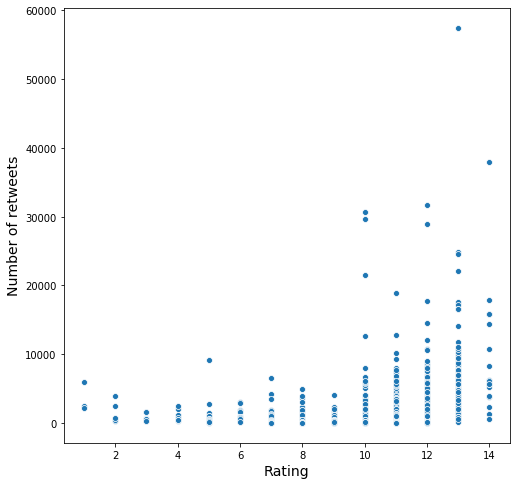

In [328]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df.rating_numerator, df.retweet_count);
plt.ylabel("Number of retweets",fontsize=14);
plt.xlabel("Rating",fontsize=14);
plt.title("",fontsize = 16);

### 2. How favourite count correlates with the score

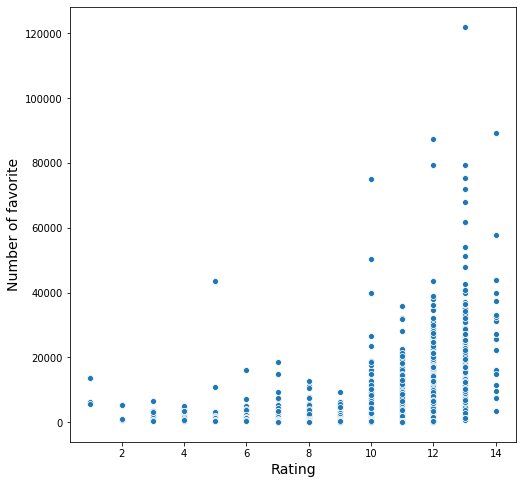

In [329]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df.rating_numerator, df.favorite_count);
plt.ylabel("Number of favorite",fontsize=14);
plt.xlabel("Rating",fontsize=14);
plt.title("",fontsize = 16);

### 3. How favourite count correlates with retweets count

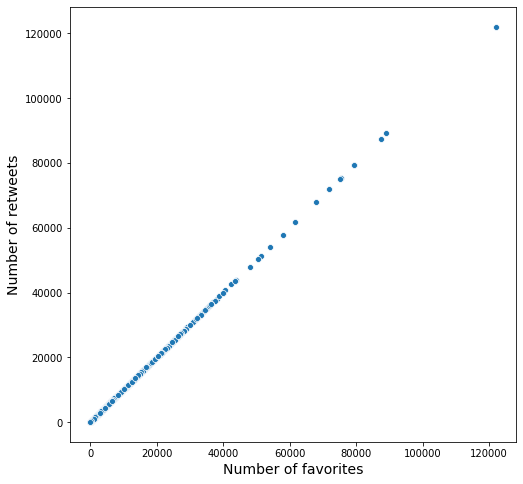

In [330]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df.favorite_count, df.favorite_count);
plt.ylabel("Number of retweets",fontsize=14);
plt.xlabel("Number of favorites",fontsize=14);
plt.title("",fontsize = 16);

### 4. Which breeds are among top 20 predictions

In [255]:
temp = df.query('is_first_prediction_dog == 1').groupby('first_prediction').count().sort_values('timestamp',ascending=False).head(20)

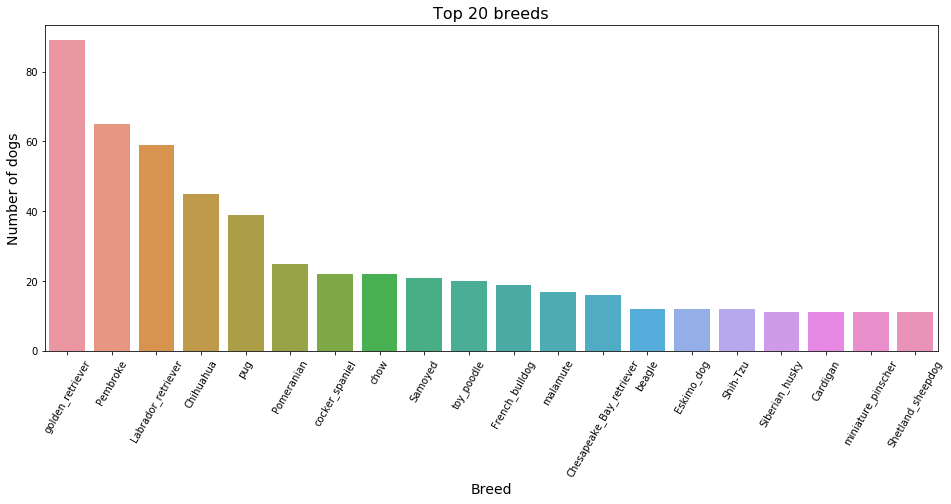

In [316]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=60)
sns.barplot(temp.index, temp.timestamp);
plt.ylabel("Number of dogs",fontsize=14);
plt.xlabel("Breed",fontsize=14);
plt.title("Top 20 breeds", fontsize = 16);

### 5. How the number of tweets changes over time

In [295]:
data = df.groupby([df.timestamp.dt.year ,df.timestamp.dt.month]).count()[['text']]

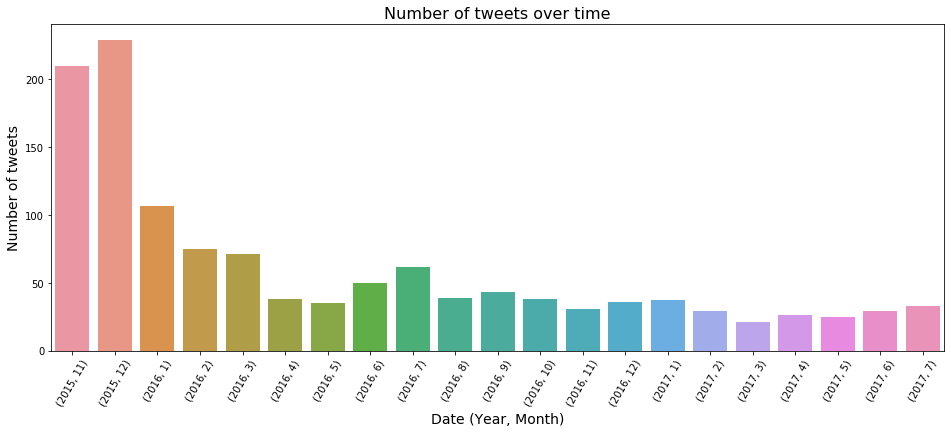

In [315]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=60)
sns.barplot(x=data.index, y='text', data=data);
plt.ylabel("Number of tweets",fontsize=14);
plt.xlabel("Date (Year, Month)",fontsize=14);
plt.title("Number of tweets over time",fontsize = 16);

### 6. Which words were used the most in the tweets
`conda install -c conda-forge wordcloud`

In [140]:
allTweets = "".join(str(text) for text in df.text)

In [141]:
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [142]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    listOfWords = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    listOfWords2=[];
    for word in listOfWords:
        listOfWords2.append(porter.stem(word))
    return ' '.join(listOfWords2)

allTweets_processed = text_process(allTweets)

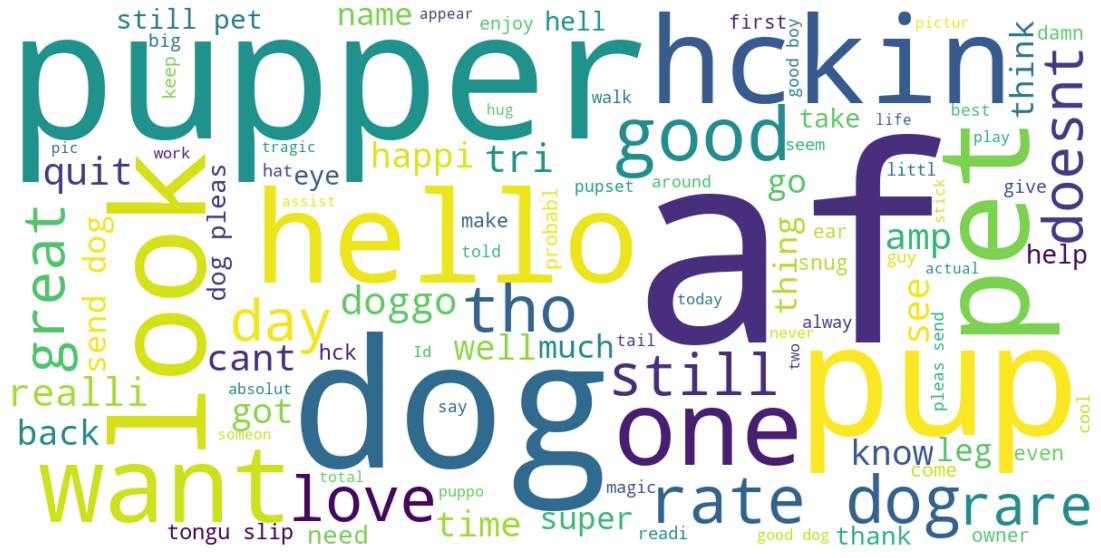

In [143]:
def drawWordCloud(text):
    wordcloud = WordCloud(width=1200, height=600,max_font_size=300, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

drawWordCloud(allTweets_processed)

### 7. What is the relationship between breeds and prediction confidence
(Only included dogs with a frequency of 10 or more)

In [322]:
temp = df.query('is_first_prediction_dog == 1').groupby('first_prediction').count().sort_values('timestamp',ascending=False)
breeds = temp.query('timestamp >= 10').index

data = df.query('first_prediction in @breeds').groupby('first_prediction').mean().sort_values('first_prediction_confidence',ascending=False)[['first_prediction_confidence', 'second_prediction_confidence', 'third_prediction_confidence']]
data['breed'] = data.index
data = data.melt(id_vars = ['breed'])

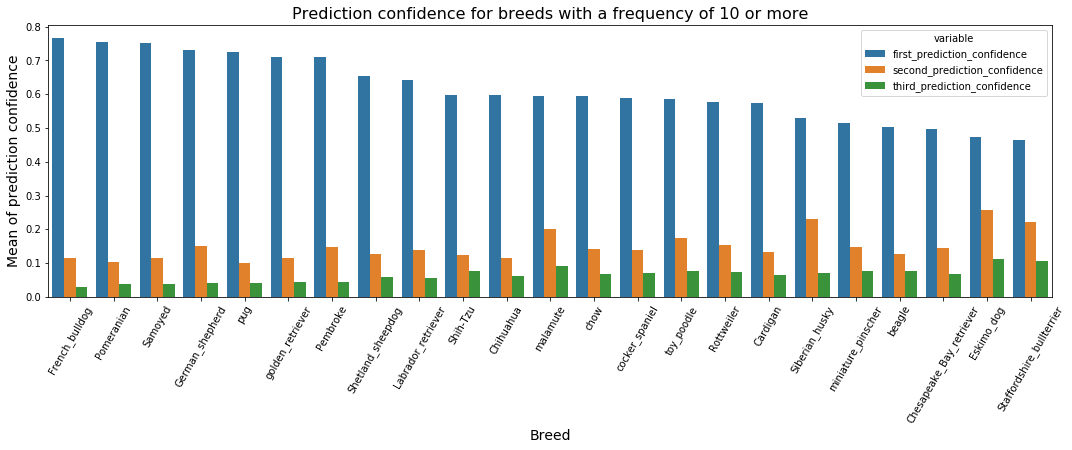

In [323]:
plt.figure(figsize=(18, 5))
plt.xticks(rotation=60)
sns.barplot(x='breed', y='value', hue ='variable' , data=data);
plt.ylabel("Mean of prediction confidence",fontsize=14);
plt.xlabel("Breed",fontsize=14);
plt.title("Prediction confidence for breeds with a frequency of 10 or more",fontsize = 16);

__________________________________

<a id='conclusions'></a>
# Conclusions

#### Insights:
1. There is a positive correlation between the rate of the dog and the number of retweets. Dogs with higher ratings have been retweeted more.
2. There is a positive correlation between the rate of the dog and the number of favourites. Dogs with higher ratings have been favourited more.
3. Favourite count and retweet count have a positive and strong correlation. Tweets which are retweeted more have been favourited more. 
4. The golden retriever, Pembroke and Labrador retriever are the most frequent dog breeds in the dataset.
5. December of 2015 was the busiest month, with about 220 tweets. After 2015 the number of tweets dropped to less than 100 per month. March of 2017 was the less crowded month with 20 tweets.
6. Words `pupper`, `dog`, `hello` and `af` are the most frequently used words in tweets.
7. First prediction confidence for French bulldog, Pomeranian and Samoyed breeds is the most accurate with an average confidence of  70% and more. Also, second and the third prediction confidence for these breeds are low that shows the breed prediction algorithm works the best for these breeds.